In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import interpn
from loadmodules import *

In [2]:
datadir = '/home/pdcg/Documents/post_process_routines/'
simulation = 'rlx_fixed/'
sf = load_subfind(127, dir=datadir+simulation, loadonly=['fpos', 'slty', 'frc2', 'svel', 'sidm', 'smty', 'spos', 'fnsh', 'flty', 'slty', 'ffsh'] )
s = gadget_readsnap(127, snappath=datadir+simulation, subfind=sf, applytransformationfacs=True, hdf5=True, loadonlyhalo=0)

/home/pdcg/pylib/gadget_subfind.py:443: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('int64'):
/home/pdcg/pylib/gadget_snap.py:699: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


In [3]:
s.calc_sf_indizes(sf)
center = sf.data['spos'][0,:].astype('f8')
rot_matrix = s.select_halo(sf)

galrad= 0.02143739461898804
Found 149523 stars.


In [4]:
s.data['pos'] *= 1e3 # change positions to kiloparsec
s.data['mass'] *= 1e10 # change mass to solar masses
s.data['mclt'] *= 1e10
s.data['imcl'] *= 1e10
s.data['mlrx'] *= 1e10
s.data['mlsk'] *= 1e10
s.data['mtrc'] *= 1e10

In [5]:
mask_clusters_initial = s.data['incl'] > 0
mask_clusters_final = s.data['nclt'] > 0

truncation_mass = s.data['mtrc'][mask_clusters_initial]
cluster_masses = s.data['mclt'][mask_clusters_initial].flatten()
init_cluster_masses = s.data['imcl'][mask_clusters_initial].flatten()
masslostrelax = s.data['mlrx'][mask_clusters_initial].flatten()
masslostshock = s.data['mlsk'][mask_clusters_initial].flatten()

not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

Maximum initial mass 6.75e+07 Msun
Maximum present-day mass 3.72e+07 Msun


In [6]:
disruption_time = s.data['drpt'][mask_clusters_initial].flatten()
disruption_time = disruption_time[not_empty_clusters]

clusters_birthtime = []
for i in range(len(s.data['incl'][mask_clusters_initial])):
  nclt = s.data['incl'][mask_clusters_initial][i]
  for j in range(nclt):
    clusters_birthtime.append(s.data['age'][mask_clusters_initial][i])

clusters_birthtime = np.array(clusters_birthtime)

In [7]:
age_gyr = s.cosmology_get_lookback_time_from_a(clusters_birthtime, is_flat=True)
lifetime_gyr = age_gyr - s.cosmology_get_lookback_time_from_a(disruption_time, is_flat=True)
lifetime_gyr[np.logical_not(disruption_time>0)] = 16

In [8]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

In [9]:
MW_gcmf = np.loadtxt('MW_GCMF.csv', delimiter=',')
M31_gcmf = np.loadtxt('M31_GCMF.csv', delimiter=',')

In [10]:
empfiducial_gcmf = np.loadtxt('Fiducial_emppathfinder.csv', delimiter=',')
empschecter_gcmf = np.loadtxt('Schechter_emppathfinder.csv', delimiter=',')
emosaics_gcmf = np.loadtxt('emosaics.csv', delimiter=',')

/tmp/ipykernel_75166/2494523906.py:3: RuntimeWarning: divide by zero encountered in log10
  N, _ = np.histogram(np.log10(cluster_masses), bins=np.log10(marray_gcmf))#, histtype='step', label='ICMF')


Text(0, 0.5, 'Mass Distribution')

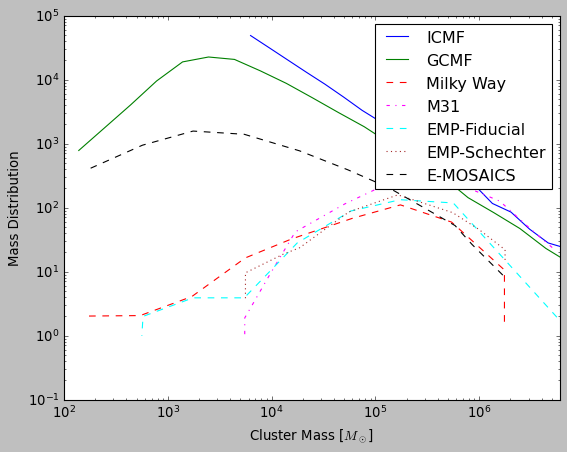

In [11]:
N, _ = np.histogram(np.log10(init_cluster_masses), bins=np.log10(marray_icmf))#, histtype='step', label='ICMF')
plt.plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
N, _ = np.histogram(np.log10(cluster_masses), bins=np.log10(marray_gcmf))#, histtype='step', label='ICMF')
plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
# plt.hist(init_cluster_masses, bins=marray_icmf, histtype='step', label='ICMF')
# plt.hist(cluster_masses, bins=marray_gcmf, histtype='step', label='GCMF')
plt.plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red', label='Milky Way')
plt.plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta', label='M31')
plt.plot(empfiducial_gcmf[:,0], empfiducial_gcmf[:,1], linestyle='dashed', color='cyan', label='EMP-Fiducial')
plt.plot(empschecter_gcmf[:,0], empschecter_gcmf[:,1], linestyle='dotted', color='brown', label='EMP-Schechter')
plt.plot(emosaics_gcmf[:,0], emosaics_gcmf[:,1], linestyle='dashed', color='black', label='E-MOSAICS')
plt.legend()
plt.xlim(min_gcmf, 6e6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Cluster Mass [$M_\odot$]')
plt.ylabel('Mass Distribution')
# plt.savefig('mass_dist_fullevo_new.pdf')

Text(0.5, 0, 'Cluster`s age [Gyr]')

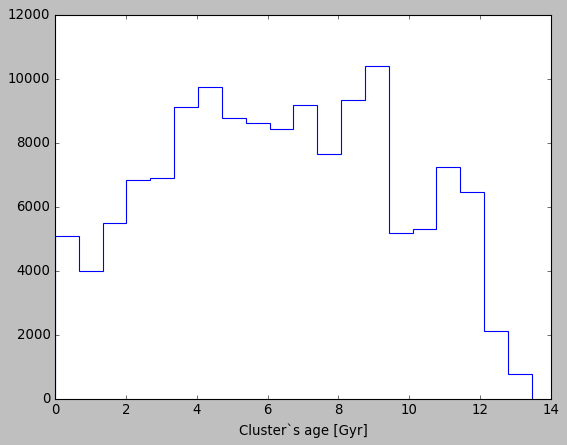

In [12]:
plt.hist(age_gyr, bins=20, histtype='step')
plt.xlabel('Cluster`s age [Gyr]')

In [13]:
young_mask = (age_gyr<0.5)
old_mask = (age_gyr>4)
veryold_mask = (age_gyr>10)

/tmp/ipykernel_75166/3966179627.py:18: RuntimeWarning: divide by zero encountered in log10
  N, _ = np.histogram(np.log10(cluster_masses[np.logical_not(young_mask)]), bins=np.log10(marray_gcmf))
/tmp/ipykernel_75166/3966179627.py:29: RuntimeWarning: divide by zero encountered in log10
  N, _ = np.histogram(np.log10(cluster_masses[old_mask]), bins=np.log10(marray_gcmf))
/tmp/ipykernel_75166/3966179627.py:41: RuntimeWarning: divide by zero encountered in log10
  N, _ = np.histogram(np.log10(cluster_masses[veryold_mask]), bins=np.log10(marray_gcmf))


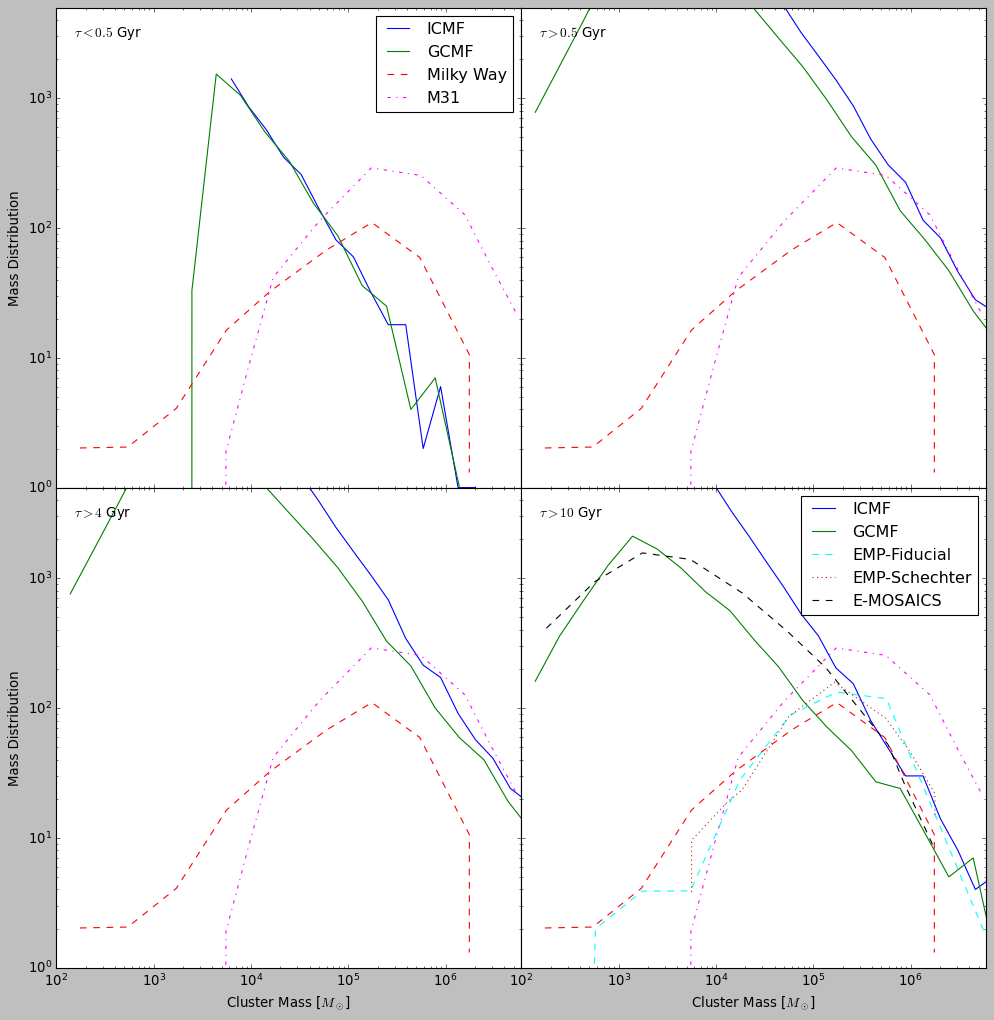

In [14]:
fig, ax = plt.subplots(2,2,sharex='col', sharey='row', figsize=(15, 15))
#Young
N, _ = np.histogram(np.log10(init_cluster_masses[young_mask]), bins=np.log10(marray_icmf))
ax[0,0].plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
N, _ = np.histogram(np.log10(cluster_masses[young_mask]), bins=np.log10(marray_gcmf))
ax[0,0].plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
# ax[0,0].hist(init_cluster_masses[young_mask], bins=marray_icmf, histtype='step', label='ICMF')
# ax[0,0].hist(cluster_masses[young_mask], bins=marray_gcmf, histtype='step', label='GCMF')
ax[0,0].plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red', label='Milky Way')
ax[0,0].plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta', label='M31')
ax[0,0].text(1.5e2, 3e3, r'$\tau < 0.5$ Gyr')
ax[0,0].set(ylim=(1e0, 5e3), xscale= 'log', yscale = 'log')
ax[0,0].legend()
ax[0,0].set(ylabel='Mass Distribution')
#Not young
N, _ = np.histogram(np.log10(init_cluster_masses[np.logical_not(young_mask)]), bins=np.log10(marray_icmf))
ax[0,1].plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
N, _ = np.histogram(np.log10(cluster_masses[np.logical_not(young_mask)]), bins=np.log10(marray_gcmf))
ax[0,1].plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
# ax[0,1].hist(init_cluster_masses[np.logical_not(young_mask)], bins=marray_icmf, histtype='step', label='ICMF')
# ax[0,1].hist(cluster_masses[np.logical_not(young_mask)], bins=marray_gcmf, histtype='step', label='GCMF')
ax[0,1].plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red', label='Milky Way')
ax[0,1].plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta', label='M31')
ax[0,1].text(1.5e2, 3e3, r'$\tau > 0.5$ Gyr')
ax[0,1].set(xscale= 'log', yscale = 'log')
#Old
N, _ = np.histogram(np.log10(init_cluster_masses[old_mask]), bins=np.log10(marray_icmf))
ax[1,0].plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
N, _ = np.histogram(np.log10(cluster_masses[old_mask]), bins=np.log10(marray_gcmf))
ax[1,0].plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
# ax[1,0].hist(init_cluster_masses[old_mask], bins=marray_icmf, histtype='step', label='ICMF')
# ax[1,0].hist(cluster_masses[old_mask], bins=marray_gcmf, histtype='step', label='GCMF')
ax[1,0].plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red', label='Milky Way')
ax[1,0].plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta', label='M31')
ax[1,0].text(1.5e2, 3e3, r'$\tau > 4$ Gyr')
ax[1,0].set(xlim=(min_gcmf, 6e6), ylim=(1e0, 5e3), xscale= 'log', yscale = 'log')
ax[1,0].set(xlabel=r'Cluster Mass [$M_\odot$]', ylabel='Mass Distribution')
#Very old
N, _ = np.histogram(np.log10(init_cluster_masses[veryold_mask]), bins=np.log10(marray_icmf))
ax[1,1].plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
N, _ = np.histogram(np.log10(cluster_masses[veryold_mask]), bins=np.log10(marray_gcmf))
ax[1,1].plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
# ax[1,1].hist(init_cluster_masses[veryold_mask], bins=marray_icmf, histtype='step')
# ax[1,1].hist(cluster_masses[veryold_mask], bins=marray_gcmf, histtype='step')
ax[1,1].plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red')
ax[1,1].plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta')
ax[1,1].plot(empfiducial_gcmf[:,0], empfiducial_gcmf[:,1], linestyle='dashed', color='cyan', label='EMP-Fiducial')
ax[1,1].plot(empschecter_gcmf[:,0], empschecter_gcmf[:,1], linestyle='dotted', color='brown', label='EMP-Schechter')
ax[1,1].plot(emosaics_gcmf[:,0], emosaics_gcmf[:,1], linestyle='dashed', color='black', label='E-MOSAICS')
ax[1,1].text(1.5e2, 3e3, r'$\tau > 10$ Gyr')
ax[1,1].set(xlim=(min_gcmf, 6e6), xscale= 'log', yscale = 'log')
ax[1,1].set(xlabel=r'Cluster Mass [$M_\odot$]')
ax[1,1].legend()

fig.subplots_adjust(hspace=0, wspace=0)
# plt.savefig('mass_dist_fullevo_age_new.pdf')

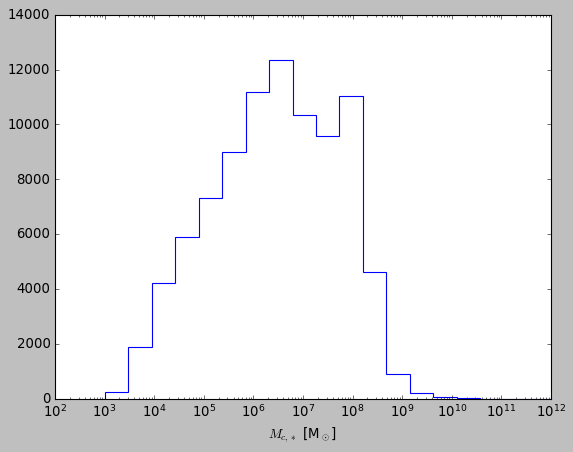

In [15]:
bins = np.logspace(3,12,20)
plt.hist(truncation_mass, bins=bins, histtype='step')
plt.xlabel(r'$M_{c,\ast}$ [M$_\odot$]')
plt.xscale('log')

In [16]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, **kwargs )

    return ax, h

In [17]:
fraction = []
for i in range(24):
  mask = (init_cluster_masses > marray_icmf[i]) & (init_cluster_masses < marray_icmf[i+1])
  mask_disrupted = (disruption_time[mask]>0)
  fraction.append(mask_disrupted.sum()/mask.sum())

fraction = np.array(fraction)
fraction = np.nan_to_num(fraction, nan=0.)

/tmp/ipykernel_75166/478416180.py:5: RuntimeWarning: invalid value encountered in long_scalars
  fraction.append(mask_disrupted.sum()/mask.sum())


Text(0, 0.5, 'Number')

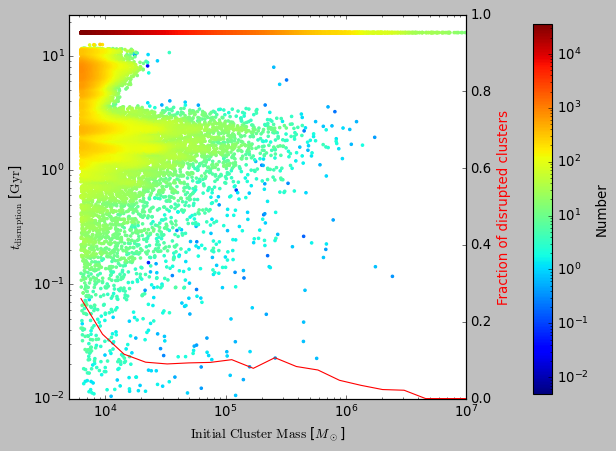

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()
ax1, cb = density_scatter(init_cluster_masses, lifetime_gyr, ax=ax1, bins=[marray_icmf, np.logspace(-2,1.5,100)], edgecolors='face', s=5, norm='log')
ax1.set(xscale='log', yscale='log', xlim=(5e3, 1e7), ylim=(1e-2, 2.3e1))
ax1.set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Gyr}$]')
ax2.plot((marray_icmf[:-1] + marray_icmf[1:])/2, fraction, color='r')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Fraction of disrupted clusters', color='r')

cbar = fig.colorbar(cb, ax=ax1)
# Move the colorbar to a new position
new_position = fig.add_axes([0.85, 0.11, 0.03, 0.77])
cbar.ax.remove()
cbar = fig.colorbar(cb, cax=new_position)
cbar.ax.set_ylabel('Number')
# plt.savefig('disrupted_new.pdf')

In [19]:
mevminit = masslostrelax/init_cluster_masses
mshminit = masslostshock/init_cluster_masses
mshminit[(mshminit>1)] = 1

Text(0, 0.5, 'Number')

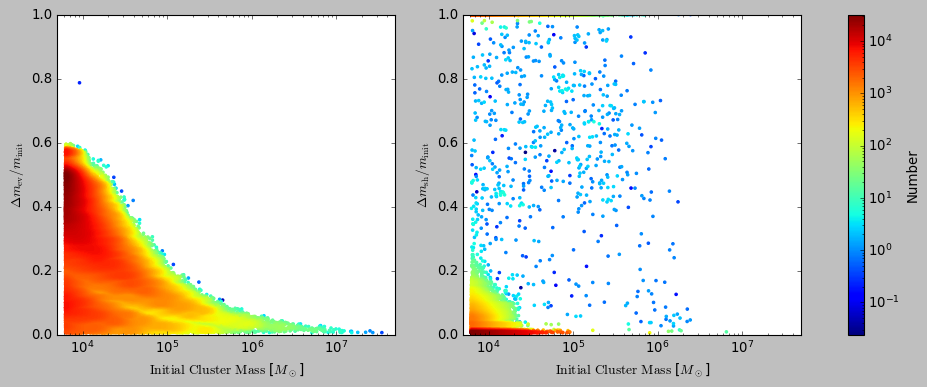

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0], cb = density_scatter(init_cluster_masses, mevminit, ax=ax[0],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5, norm='log')
ax[1], cb = density_scatter(init_cluster_masses, mshminit, ax=ax[1],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5, norm='log')
ax[0].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$')
ax[1].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb, ax=ax)
cbar.ax.set_ylabel('Number')
# plt.savefig('lostmass_new.pdf')